In [36]:
import copy
import os
import time
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from tqdm import tqdm
import csv
from torchvision.utils import save_image
import numpy as np
from skimage.transform import PiecewiseAffineTransform, warp
from random import randrange
from numpy import asarray
from PIL import Image, ImageOps, ImageChops, ImageDraw, ImageFilter

In [2]:
# Define constants
BATCH_SIZE = 16
NUM_EPOCHS = 20
LR = 0.001
np.random.seed(0)
torch.manual_seed(0)

base_dir = os.path.join("/home/student/hw2_094295", "data")
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# f = open('/home/student/hw2_094295/attempts.csv', 'a')
# writer = csv.writer(f)
# writer.writerow(["description", "acc_dict", "final_acc_train", "final_acc_val"])
# f.close()

### Noise functions

In [32]:
def salt_and_pepper_augmentation(image, amount):
    output = np.copy(np.array(image))
    
    # add salt
    nb_salt = np.ceil(amount * output.size * 0.5)
    coords = [np.random.randint(0, i - 1, int(nb_salt)) for i in output.shape]
    output[tuple(coords)] = 255
    
    # add pepper
    nb_pepper = np.ceil(amount * output.size * 0.5)
    coords = [np.random.randint(0, i - 1, int(nb_pepper)) for i in output.shape]
    output[tuple(coords)] = 0
    
    return Image.fromarray(output)


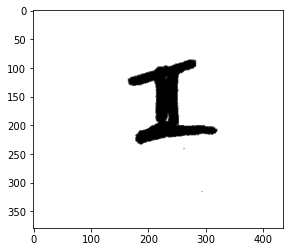

In [4]:
img = Image.open("/home/student/hw2_094295/data/train/i/ab4e0182-ce5d-11eb-b317-38f9d35ea60f.png")
plt.imshow(img, cmap="gray")
plt.show()

In [61]:
def load_datasets(train_directory, val_directory, type_of_transform):
    """Loads and transforms the datasets."""

    data_transforms_with_crop = transforms.Compose([transforms.Resize([120,120]), 
                                                    transforms.ToTensor(), 
                                                    transforms.RandomCrop(110, padding=20)])
    
    data_transforms_with_rotation = transforms.Compose([transforms.Resize([120,120]), 
                                                    transforms.ToTensor(), 
                                                    transforms.RandomRotation(20, fill=255)])    
    
    data_transforms = transforms.Compose([transforms.ToTensor()])
    
    if type_of_transform == "random crop":
        # Create a pytorch dataset from a directory of images
        train_dataset = datasets.ImageFolder(train_directory, data_transforms_with_crop)
        val_dataset = datasets.ImageFolder(val_directory, data_transforms_with_crop)

    if type_of_transform == "random rotation":
        # Create a pytorch dataset from a directory of images
        train_dataset = datasets.ImageFolder(train_directory, data_transforms_with_rotation)
        val_dataset = datasets.ImageFolder(val_directory, data_transforms_with_rotation)

    if type_of_transform == "regular":
        # Create a pytorch dataset from a directory of images
        train_dataset = datasets.ImageFolder(train_directory, data_transforms)
        val_dataset = datasets.ImageFolder(val_directory, data_transforms)
        

    return train_dataset, val_dataset


In [6]:
# Extracting class names
original_train_dataset, original_val_dataset = load_datasets(train_dir, val_dir, "random crop")
class_names = original_train_dataset.classes
print(class_names)

['i', 'ii', 'iii', 'iv', 'ix', 'v', 'vi', 'vii', 'viii', 'x']


### Saving original images by the order of the reading in the dataset

In [20]:
# Creating folder and labels sub-folders
os.mkdir("/home/student/hw2_094295/augmentations")
os.mkdir("/home/student/hw2_094295/augmentations/Regular")
original_train_dataset, original_val_dataset = load_datasets(train_dir, val_dir, "Regular")

for label in class_names:
     path = os.path.join("/home/student/hw2_094295/augmentations/Regular", label)
     os.mkdir(path)

# path of dir
aug_dir = "/home/student/hw2_094295/augmentations/Regular"

# creating images and saving them
label_index = 0
for label in tqdm(class_names):
    label_dir = os.path.join(aug_dir, label)
    for dataset in [original_train_dataset, original_val_dataset]:
        indices = [i for i in range(len(dataset)) if dataset[i][1] == label_index]
        for idx in indices:
            save_image(dataset[idx][0], label_dir + f"/{label}_{idx}_Regular.png")
    label_index+=1

100%|██████████| 10/10 [00:27<00:00,  2.74s/it]


### Saving images with salt&pepper noise applied

In [33]:
# # Creating folder and labels sub-folders
os.mkdir("/home/student/hw2_094295/augmentations/salt_and_pepper")

for label in class_names:
     path = os.path.join("/home/student/hw2_094295/augmentations/salt_and_pepper", label)
     os.mkdir(path)

# path of dir
noise_dir = "/home/student/hw2_094295/augmentations/salt_and_pepper"
regular_images_path = "/home/student/hw2_094295/augmentations/Regular/"
# creating noised images and saving them
for label in tqdm(class_names):
    label_dir = os.path.join(noise_dir, label)
    files = os.listdir(regular_images_path+label)
    for file in files:
        file_name_values = file.split("_")
        file_name_values[-1] = "s&p.png"
        new_file_name = "_".join(file_name_values)
        img = Image.open(f"{regular_images_path+label}/{file}").convert('L')
        image = salt_and_pepper_augmentation(img, 0.4)
        image.save(label_dir + "/" + new_file_name)


100%|██████████| 10/10 [00:17<00:00,  1.73s/it]


### Saving images with Random crop applied

In [35]:
# Creating folder and labels sub-folders
os.mkdir("/home/student/hw2_094295/augmentations/Random_crop")
original_train_dataset, original_val_dataset = load_datasets(train_dir, val_dir, "random crop")

for label in class_names:
     path = os.path.join("/home/student/hw2_094295/augmentations/Random_crop", label)
     os.mkdir(path)

# path of dir
aug_dir = "/home/student/hw2_094295/augmentations/Random_crop"

# creating noised images and saving them
label_index = 0
for label in tqdm(class_names):
    label_dir = os.path.join(aug_dir, label)
    for dataset in [original_train_dataset, original_val_dataset]:
        indices = [i for i in range(len(dataset)) if dataset[i][1] == label_index]
        for idx in indices:
            save_image(dataset[idx][0], label_dir + f"/{label}_{idx}_RandomCrop.png")
    label_index+=1

100%|██████████| 10/10 [00:31<00:00,  3.16s/it]


### Saving images with noise from other images applied

In [44]:
# Creating folder and labels sub-folders
os.mkdir("/home/student/hw2_094295/augmentations/noised_by_other")

for label in class_names:
     path = os.path.join("/home/student/hw2_094295/augmentations/noised_by_other", label)
     os.mkdir(path)

noise_dir = "/home/student/hw2_094295/augmentations/noised_by_other"
regular_images_path = "/home/student/hw2_094295/augmentations/Regular/"

# creating noised images and saving them
for label in tqdm(class_names):
    label_dir = os.path.join(noise_dir, label)
    files = os.listdir(regular_images_path+label)
    for file in files:
        file_name_values = file.split("_")
        file_name_values[-1] = "noiseByOther.png"
        new_file_name = "_".join(file_name_values)

        source_image = Image.open(f"{regular_images_path+label}/{file}").convert('L')
        noise_path = "/home/student/hw2_094295/noisy_background/noise_" + str(np.random.randint(0,20))+".png"
        noise_image = Image.open(noise_path).convert('L').resize(source_image.size)

        random_choice = np.random.randint(1, 4)
        if random_choice == 1:
            noise_image = noise_image.transpose(Image.FLIP_TOP_BOTTOM)
        elif random_choice == 2:
            noise_image = ImageOps.mirror(noise_image)
        else:
            noise_image = noise_image.transpose(Image.FLIP_TOP_BOTTOM)
            noise_image = ImageOps.mirror(noise_image)

        noisy_image = Image.blend(source_image.convert('L'), noise_image, 0.3)
        noisy_image.save(label_dir + "/" + new_file_name)


100%|██████████| 10/10 [00:05<00:00,  1.68it/s]


### Saving images with Random Rotation of 20 degrees applied

In [48]:
# Creating folder and labels sub-folders
os.mkdir("/home/student/hw2_094295/augmentations/Random_rotation")
original_train_dataset, original_val_dataset = load_datasets(train_dir, val_dir, "random rotation")

for label in class_names:
     path = os.path.join("/home/student/hw2_094295/augmentations/Random_rotation", label)
     os.mkdir(path)

# path of dir
aug_dir = "/home/student/hw2_094295/augmentations/Random_rotation"

# creating noised images and saving them
label_index = 0
for label in tqdm(class_names):
    label_dir = os.path.join(aug_dir, label)
    for dataset in [original_train_dataset, original_val_dataset]:
        indices = [i for i in range(len(dataset)) if dataset[i][1] == label_index]
        for idx in indices:
            save_image(dataset[idx][0], label_dir + f"/{label}_{idx}_RandomRotation.png")
    label_index+=1

100%|██████████| 10/10 [00:50<00:00,  5.05s/it]


### saving rotated and cropped images with salt & pepper noise

In [65]:
# Creating folder and labels sub-folders
os.mkdir("/home/student/hw2_094295/augmentations/Rotation_with_salt_and_pepper")

for label in class_names:
     path = os.path.join("/home/student/hw2_094295/augmentations/Rotation_with_salt_and_pepper", label)
     os.mkdir(path)

# path of dir
noise_dir = "/home/student/hw2_094295/augmentations/Rotation_with_salt_and_pepper"
images_path = "/home/student/hw2_094295/augmentations/Random_rotation/"

# creating noised images and saving them
for label in tqdm(class_names):
    label_dir = os.path.join(noise_dir, label)
    files = os.listdir(images_path+label)
    for file in files:
        file_name_values = file.split("_")
        file_name_values[-1] = "RandomRotationAndS&P.png"
        new_file_name = "_".join(file_name_values)
        img = Image.open(f"{images_path+label}/{file}").convert('L')
        image = salt_and_pepper_augmentation(img, 0.4)
        image.save(label_dir + "/" + new_file_name)


# Creating folder and labels sub-folders
os.mkdir("/home/student/hw2_094295/augmentations/Random_crop_with_salt_and_pepper")
dataset, _ = load_datasets("/home/student/hw2_094295/augmentations/salt_and_pepper/", val_dir, "random crop")

for label in class_names:
     path = os.path.join("/home/student/hw2_094295/augmentations/Random_crop_with_salt_and_pepper", label)
     os.mkdir(path)

# path of dir
aug_dir = "/home/student/hw2_094295/augmentations/Random_crop_with_salt_and_pepper"

# creating noised images and saving them
label_index = 0
for label in tqdm(class_names):
    label_dir = os.path.join(aug_dir, label)
    indices = [i for i in range(len(dataset)) if dataset[i][1] == label_index]
    for idx in indices:
        save_image(dataset[idx][0], label_dir + f"/{label}_{idx}_RandomCropAndS&P.png")
    label_index+=1

100%|██████████| 10/10 [00:37<00:00,  3.74s/it]


### Saving rotated and cropped images with noise from other images applied

In [66]:
# Creating folder and labels sub-folders
os.mkdir("/home/student/hw2_094295/augmentations/Rotation_with_noise_by_other")

for label in class_names:
     path = os.path.join("/home/student/hw2_094295/augmentations/Rotation_with_noise_by_other", label)
     os.mkdir(path)

noise_dir = "/home/student/hw2_094295/augmentations/Rotation_with_noise_by_other"
regular_images_path = "/home/student/hw2_094295/augmentations/Random_rotation/"

# creating noised images and saving them
for label in tqdm(class_names):
    label_dir = os.path.join(noise_dir, label)
    files = os.listdir(regular_images_path+label)
    for file in files:
        file_name_values = file.split("_")
        file_name_values[-1] = "RandomRotationAndNoiseByOthers.png"
        new_file_name = "_".join(file_name_values)

        source_image = Image.open(f"{regular_images_path+label}/{file}").convert('L')
        noise_path = "/home/student/hw2_094295/noisy_background/noise_" + str(np.random.randint(0,20))+".png"
        noise_image = Image.open(noise_path).convert('L').resize(source_image.size)

        random_choice = np.random.randint(1, 4)
        if random_choice == 1:
            noise_image = noise_image.transpose(Image.FLIP_TOP_BOTTOM)
        elif random_choice == 2:
            noise_image = ImageOps.mirror(noise_image)
        else:
            noise_image = noise_image.transpose(Image.FLIP_TOP_BOTTOM)
            noise_image = ImageOps.mirror(noise_image)

        noisy_image = Image.blend(source_image.convert('L'), noise_image, 0.3)
        noisy_image.save(label_dir + "/" + new_file_name)


100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


### Calculating mean and std of the Images to Normalize them

In [8]:
original_train_dataset, original_val_dataset = load_datasets(train_dir, val_dir)
train_val_sets = torch.utils.data.ConcatDataset([original_train_dataset, original_val_dataset])
images = torch.stack([img_t for img_t, _ in train_val_sets], dim=3)
images_mean = images.view(3, -1).mean(dim=1)
images_std = images.view(3, -1).std(dim=1)
print(f"images mean: {images_mean}")
print(f"images std: {images_std}")

1790


TypeError: exceptions must derive from BaseException

In [30]:
def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=100):
    """Responsible for running the training and validation phases for the requested model."""
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    loss_dict = {'train': [], 'val': []}
    acc_dict = {'train': [], 'val': []}

    for epoch in tqdm(range(num_epochs)):
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() 
            else:
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # track history only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            acc_dict[phase].append(epoch_acc.item())
            loss_dict[phase].append(epoch_loss)

            if epoch%10 == 0:
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase, epoch_loss, epoch_acc))

            # If the current epoch provides the best validation accuracy so far, save the model's weights.
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, loss_dict, acc_dict

In [31]:
def save_attempt_to_csv(description, acc_dict):
    f = open('/home/student/hw2_094295/attempts.csv', 'a')
    writer = csv.writer(f)
    writer.writerow([description, acc_dict, acc_dict["train"][-1], acc_dict["val"][-1]])
    f.close()

In [85]:
def run(desc_to_csv):

    # Build dataloaders
    original_train_dataset, original_val_dataset = load_datasets(train_dir, val_dir)
    train_val_sets = torch.utils.data.ConcatDataset([original_train_dataset, original_val_dataset])
    all_dataloader = torch.utils.data.DataLoader(train_val_sets, batch_size=BATCH_SIZE, shuffle=True)
    train_size = int(0.8*len(train_val_sets))
    val_size = len(train_val_sets)-train_size
    train_dataset, val_dataset = torch.utils.data.random_split(train_val_sets, [train_size, val_size])
    plt.imshow(original_train_dataset[0][0].permute(1,2,0))
    plt.show()
    raise()


    class_names = original_train_dataset.classes
    NUM_CLASSES = len(class_names)

    # Dataloaders initialization
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
    dataloaders = {'train': train_dataloader, 'val': val_dataloader}
    dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

    #Define model and constants
    model_ft = models.resnet50(pretrained=False)

    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, NUM_CLASSES)

    model_ft = model_ft.to(device)

    criterion = nn.CrossEntropyLoss()

    optimizer_ft = optim.Adam(model_ft.parameters(), lr=LR)

    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

    # Train the model
    model_ft, loss_dict, acc_dict = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, dataloaders, dataset_sizes, num_epochs=NUM_EPOCHS)
    save_attempt_to_csv(desc_to_csv, acc_dict)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


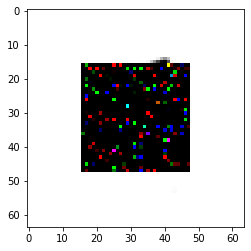

TypeError: exceptions must derive from BaseException

Bad pipe message: %s [b'\x9e\xb0\x9f\x87\xf9\xcb']
Bad pipe message: %s [b'\xc3\xbd\x9f\xc0j\xd4\xfc\xbe&\xb1\xb1bm\\\x01M\x96D\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc']
Bad pipe message: %s [b"\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0#\xc0'\x00g\x00@\xc0\n\xc0\x14\x009\x008\xc0\t\xc0\x13\x003\x002\x00\x9d\xc0\xa1\xc0\x9d\xc0Q\x00\x9c\xc0\xa0\xc0\x9c\xc0P\x00=\x00<\x005\x00/\x00\x9a\x00\x99\xc0\x07\xc0\x11\x00\x96\x00\x05\x00\xff\x01\x00\x00j\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00"]
Bad pipe message: %s [b'\x00\x00\r\x000\x00.\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08\t\x08\n\x08']
Bad pipe message: %s [b'\x04\x08\x05\x08\x06\x04\x01\x05\x01\x06']
Bad pipe message: %s [b'', b'\x03\x03']
Bad pipe message: %s [b'']
Bad pipe message: %s 

In [90]:
run("with normalization, 80% train and 20% test")

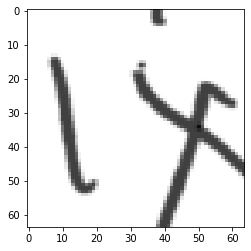

TypeError: exceptions must derive from BaseException

In [51]:
run("with normalization, 80% train and 20% test")

## Saving the model and generating accuracy and loss plots

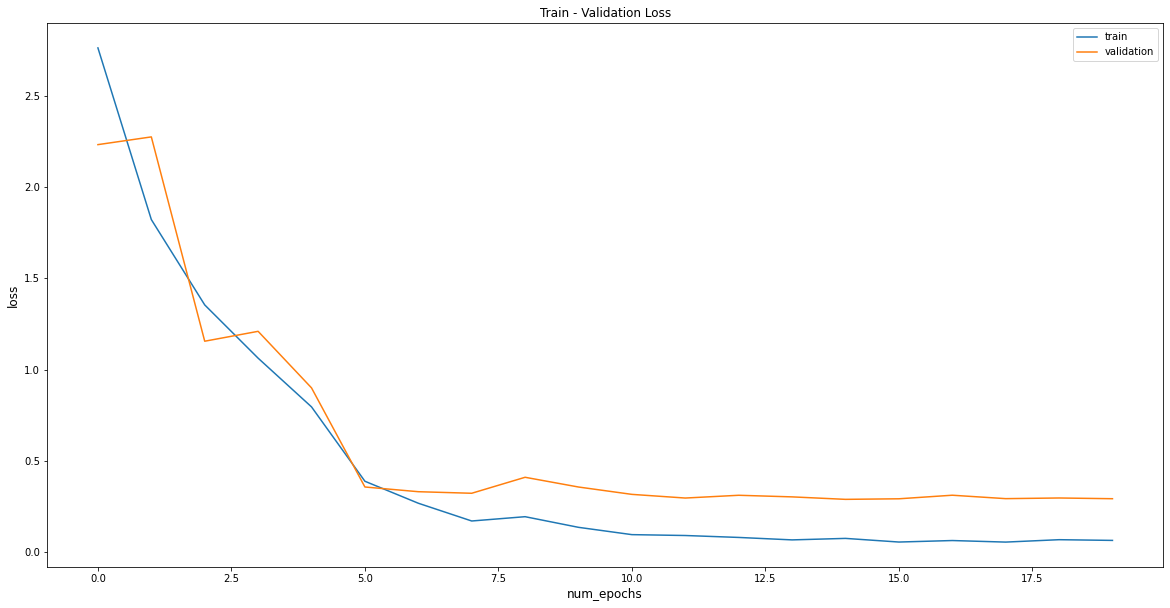

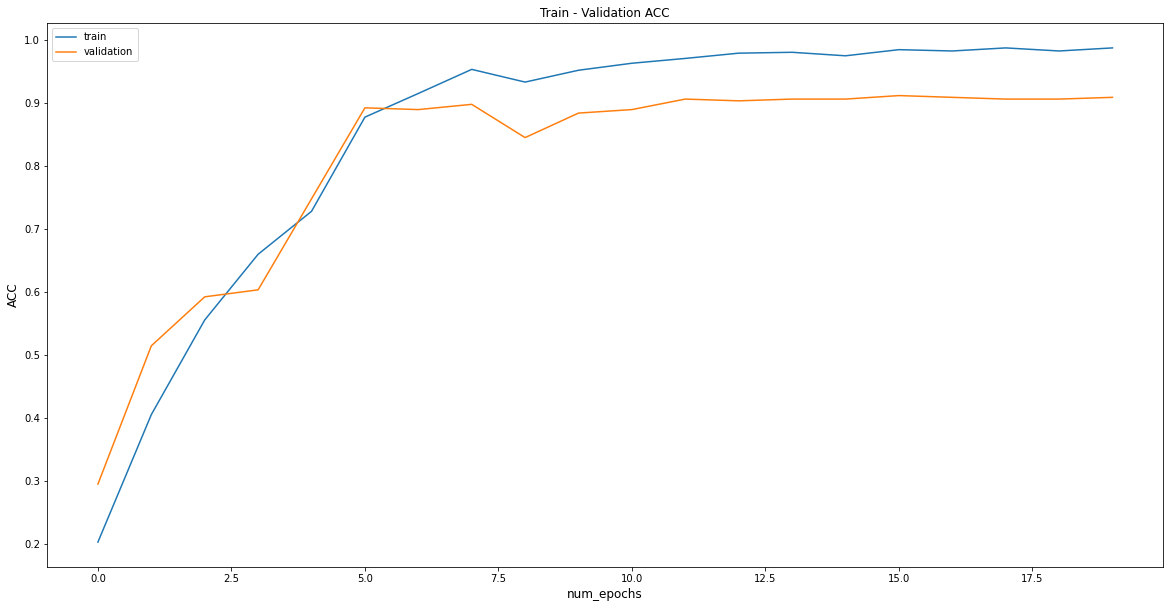

In [51]:
# Save the trained model
models_dir = os.path.join('/home/student/hw2_094295', 'models')
os.makedirs(models_dir, exist_ok=True)
torch.save(model_ft.state_dict(), os.path.join(models_dir, "trained_model.pt"))

figures_dir = os.path.join('/home/student/hw2_094295', 'figures')
os.makedirs(figures_dir, exist_ok=True)

# Basic visualizations of the model performance
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Loss")
plt.plot(loss_dict['train'], label='train')
plt.plot(loss_dict['val'], label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(loc='best')
plt.savefig(os.path.join(figures_dir, 'train_val_loss_plot.png'))

fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation ACC")
plt.plot(acc_dict['train'], label='train')
plt.plot(acc_dict['val'], label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('ACC', fontsize=12)
plt.legend(loc='best')
plt.savefig(os.path.join(figures_dir, 'train_val_acc_plot.png'))